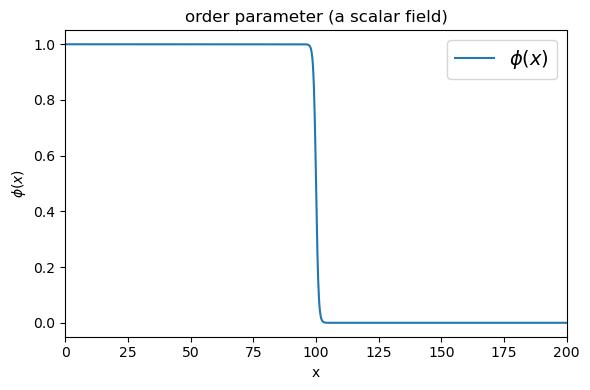

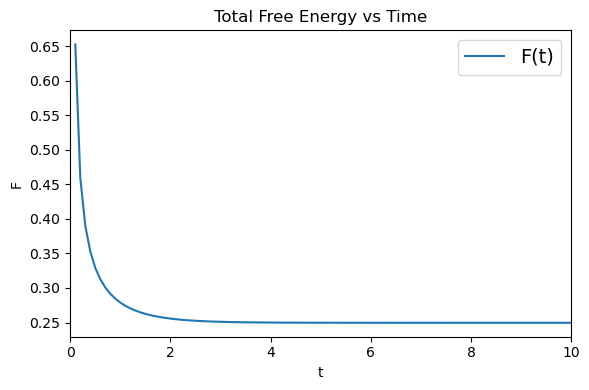

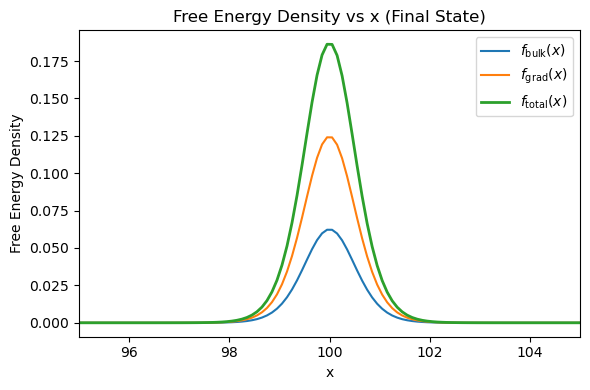

In [1]:
from fipy import *
import matplotlib.pyplot as plt

# Mesh
dx = 0.1
Lx = 200.
nx = int(Lx/dx)
mesh = Grid1D(dx=dx, nx=nx)
x = mesh.cellCenters[0]

# Define field varialbe
phi = CellVariable(mesh=mesh, hasOld=1)

# Define initial condition -> Step Function
phi.setValue(0.0)                         # Set everything to 0
phi.setValue(1.0, where=x < Lx / 2)       # Set left half (x < 100) to 1

# Boundary condtion
phi.faceValue.constrain(value=1., where=mesh.facesLeft)
phi.faceGrad.constrain(value=0., where=mesh.facesRight)

# Define equation coefficients
rho = 1. ; u = (0.,) ; K_phi = 1.; Gamma = K_phi/2 ; f_0 = 1. ; L = 1. ; a = 4. * f_0 ; b = - 6. * f_0 ; c = 2. * f_0 ; d = 0

# Define equation
s0 = d
s1 = a * phi**2 + b * phi + c
eq = TransientTerm(coeff=rho) == -L * ( - ConvectionTerm(coeff=u) \
- DiffusionTerm(coeff=Gamma) \
+ ImplicitSourceTerm(coeff=s1) \
+ s0 )

# Solver
dt = 0.1
steps = 100

times = []
energies = []
for step in range(steps):
    phi.updateOld()
    res = 1.e5
    while res > 1.e-2:    # much looser, far fewer sweeps
        res = eq.sweep(var=phi, dt=dt)
    # Calculate total free energy F(t)
    f_bulk = f_0 * (phi**2) * (1 - phi)**2
    f_grad = (0.5 * K_phi * phi.grad.mag**2).value
    f_total = f_bulk + f_grad

    F = (f_total * mesh.cellVolumes).sum()
    energies.append(F)
    times.append((step + 1) * dt)

# Plot φ(x) 
plt.figure(figsize=(6,4))
plt.plot(x, phi, label=r"$\phi(x)$")
plt.xlabel("x")
plt.ylabel("$\phi(x)$")
plt.title("order parameter (a scalar field)", fontsize=12)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()


# Plot F(t)
plt.figure(figsize=(6,4))
plt.plot(times, energies, label="F(t)")
plt.xlabel("t")
plt.ylabel("F")
plt.title("Total Free Energy vs Time", fontsize=12)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


# Plot f_bulk, f_grad, f_total vs x
plt.figure(figsize=(6,4))
plt.plot(x, f_bulk, label=r"$f_{\rm bulk}(x)$")
plt.plot(x, f_grad, label=r"$f_{\rm grad}(x)$")
plt.plot(x, f_total, label=r"$f_{\rm total}(x)$", linewidth=2)
plt.xlim(95, 105)
plt.xlabel("x")
plt.ylabel("Free Energy Density")
plt.title("Free Energy Density vs x (Final State)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

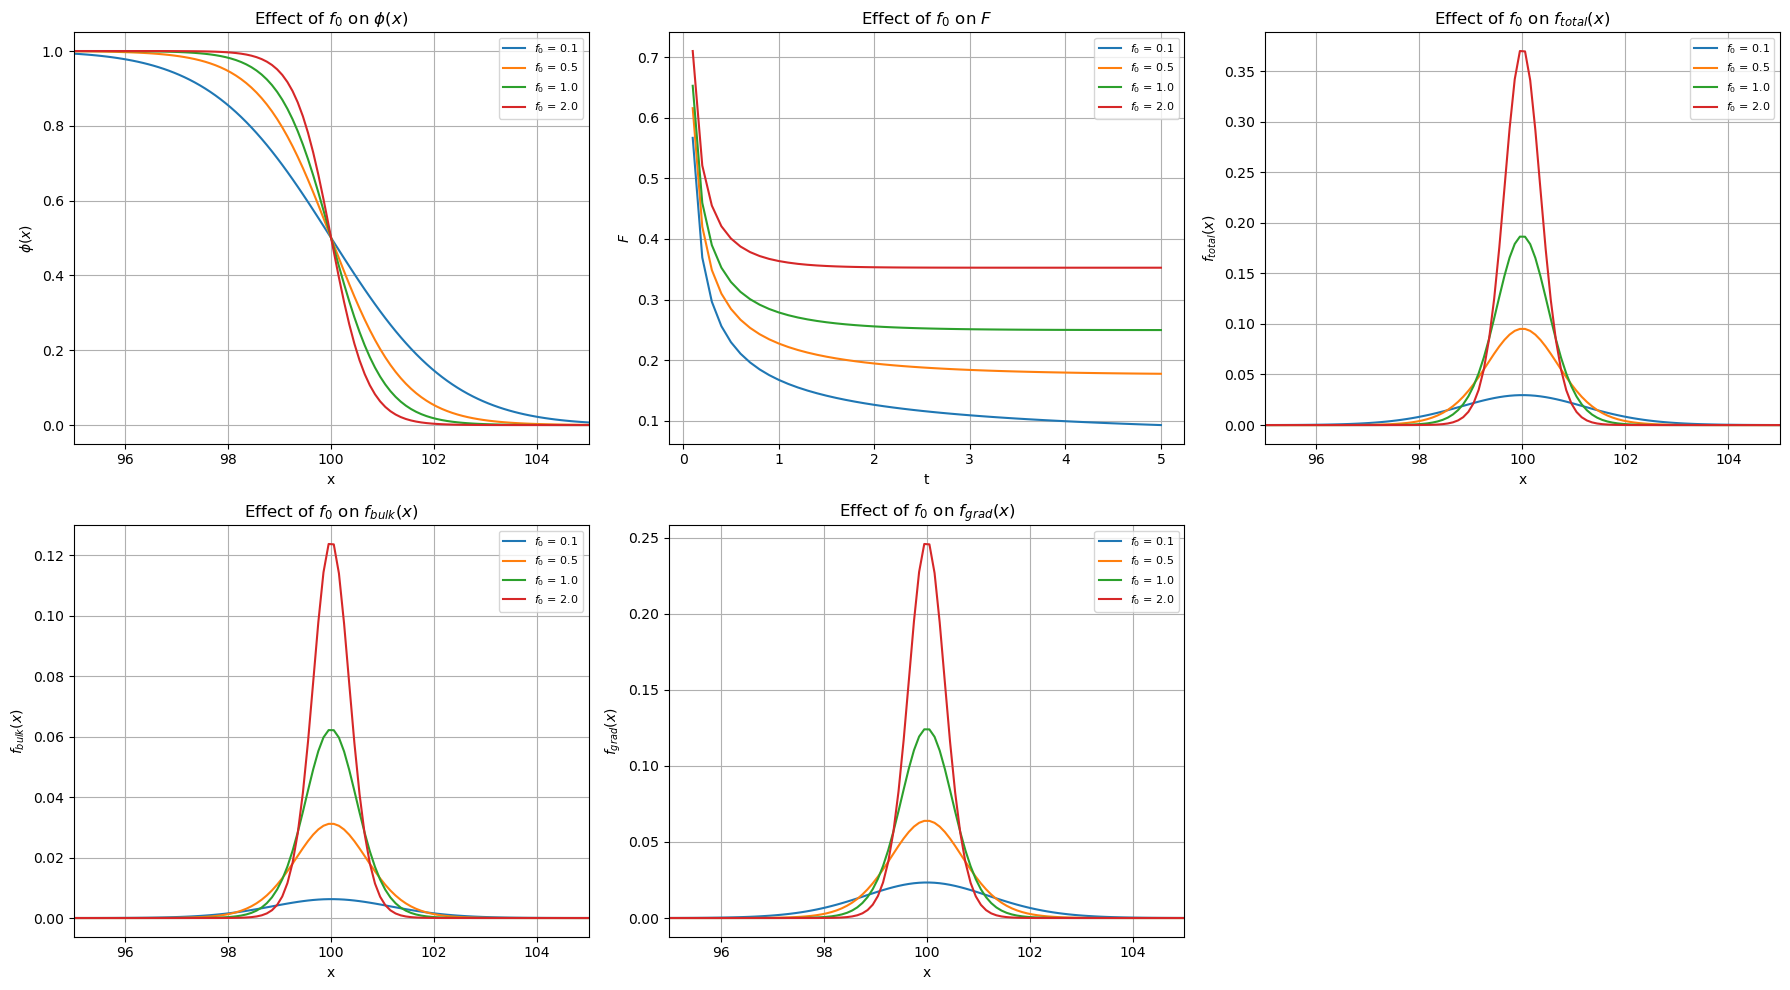

In [2]:
# Defined the function to perform the simulation with adjustable parameters (f_0, L, K_phi)
def run_simulation(f_0, L, K_phi):
    x = mesh.cellCenters[0]
    #field varialbe
    phi = CellVariable(mesh=mesh, hasOld=1)

    #initial condition Step Function
    phi.setValue(0.0)                         # Set everything to 0
    phi.setValue(1.0, where=x < Lx / 2)       # Set left half (x < 100) to 1
    
    #boundary condtion
    phi.faceValue.constrain(value=1., where=mesh.facesLeft)
    phi.faceGrad.constrain(value=0., where=mesh.facesRight)
    
    #equation coefficients
    rho = 1. ; u = (0.,) ; Gamma = K_phi/2 ; a = 4. * f_0 ; b = - 6. * f_0 ; c = 2. * f_0 ; d = 0

    #equation
    s0 = d
    s1 = a * phi**2 + b * phi + c
    eq = TransientTerm(coeff=rho) == -L * ( - ConvectionTerm(coeff=u) \
    - DiffusionTerm(coeff=Gamma) \
    + ImplicitSourceTerm(coeff=s1) \
    + s0 )

    #solver
    dt = 0.1
    steps = 50

    times = []
    energies = []
    for step in range(steps):
        phi.updateOld()
        res = 1.e5
        while res > 1.e-2:    # much looser, far fewer sweeps
            res = eq.sweep(var=phi, dt=dt)
        # Calculate free energy densities
        f_bulk = f_0 * (phi**2) * (1 - phi)**2
        f_grad = (0.5 * K_phi * phi.grad.mag**2).value
        f_total = f_bulk + f_grad
        # Calculate total free energy F(t)
        F = (f_total * mesh.cellVolumes).sum()
        energies.append(F)
        times.append((step + 1) * dt)
    return x.value, phi.value, f_bulk, f_grad, f_total, times, energies
    

'''Influence of f_0 on the phase-field evolution and energy landscape'''

# Vary f_0, keep L and K_phi fixed
f_0_values = [0.1, 0.5, 1., 2.]
L_fixed = 1.0
K_phi_fixed = 1.0


# Collect simulation results
results = []
for f_0 in f_0_values:
    result = run_simulation(f_0=f_0, L=L_fixed, K_phi=K_phi_fixed)
    results.append((f_0, *result))  # (f_0, x, phi, f_bulk, f_grad, f_total, t, F)

# Create subplot layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define what to plot
plot_configs = [
    {"ylabel": r"$\phi(x)$", "xlabel": "x", "title": r"Effect of $f_0$ on $\phi(x)$",
     "data_idx": 2},  # phi
    {"ylabel": r"$F$", "xlabel": "t", "title": r"Effect of $f_0$ on $F$",
     "data_idx": 7},  # F
    {"ylabel": r"$f_{total}(x)$", "xlabel": "x", "title": r"Effect of $f_0$ on $f_{total}(x)$",
     "data_idx": 5},  # f_total
    {"ylabel": r"$f_{bulk}(x)$", "xlabel": "x", "title": r"Effect of $f_0$ on $f_{bulk}(x)$",
     "data_idx": 3},  # f_bulk
    {"ylabel": r"$f_{grad}(x)$", "xlabel": "x", "title": r"Effect of $f_0$ on $f_{grad}(x)$",
     "data_idx": 4},  # f_grad
]

# Plotting everything
XMIN, XMAX = 95, 105   # fixed zoom region around the interface

for i, cfg in enumerate(plot_configs):
    ax = axes[i]
    for f_0, x, phi, f_bulk, f_grad, f_total, t, F in results:
        y = [phi, F, f_total, f_bulk, f_grad][i]
        x_plot = t if i == 1 else x
        ax.plot(x_plot, y, label=rf"$f_0$ = {f_0}")

    ax.set_title(cfg["title"], fontsize=12)
    ax.set_xlabel(cfg["xlabel"])
    ax.set_ylabel(cfg["ylabel"])
    ax.legend(fontsize=8)
    ax.grid(True)

    # Apply zoom to x–dependent plots
    if i != 1:  
        ax.set_xlim(XMIN, XMAX)

# Remove last empty subplot
if len(plot_configs) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

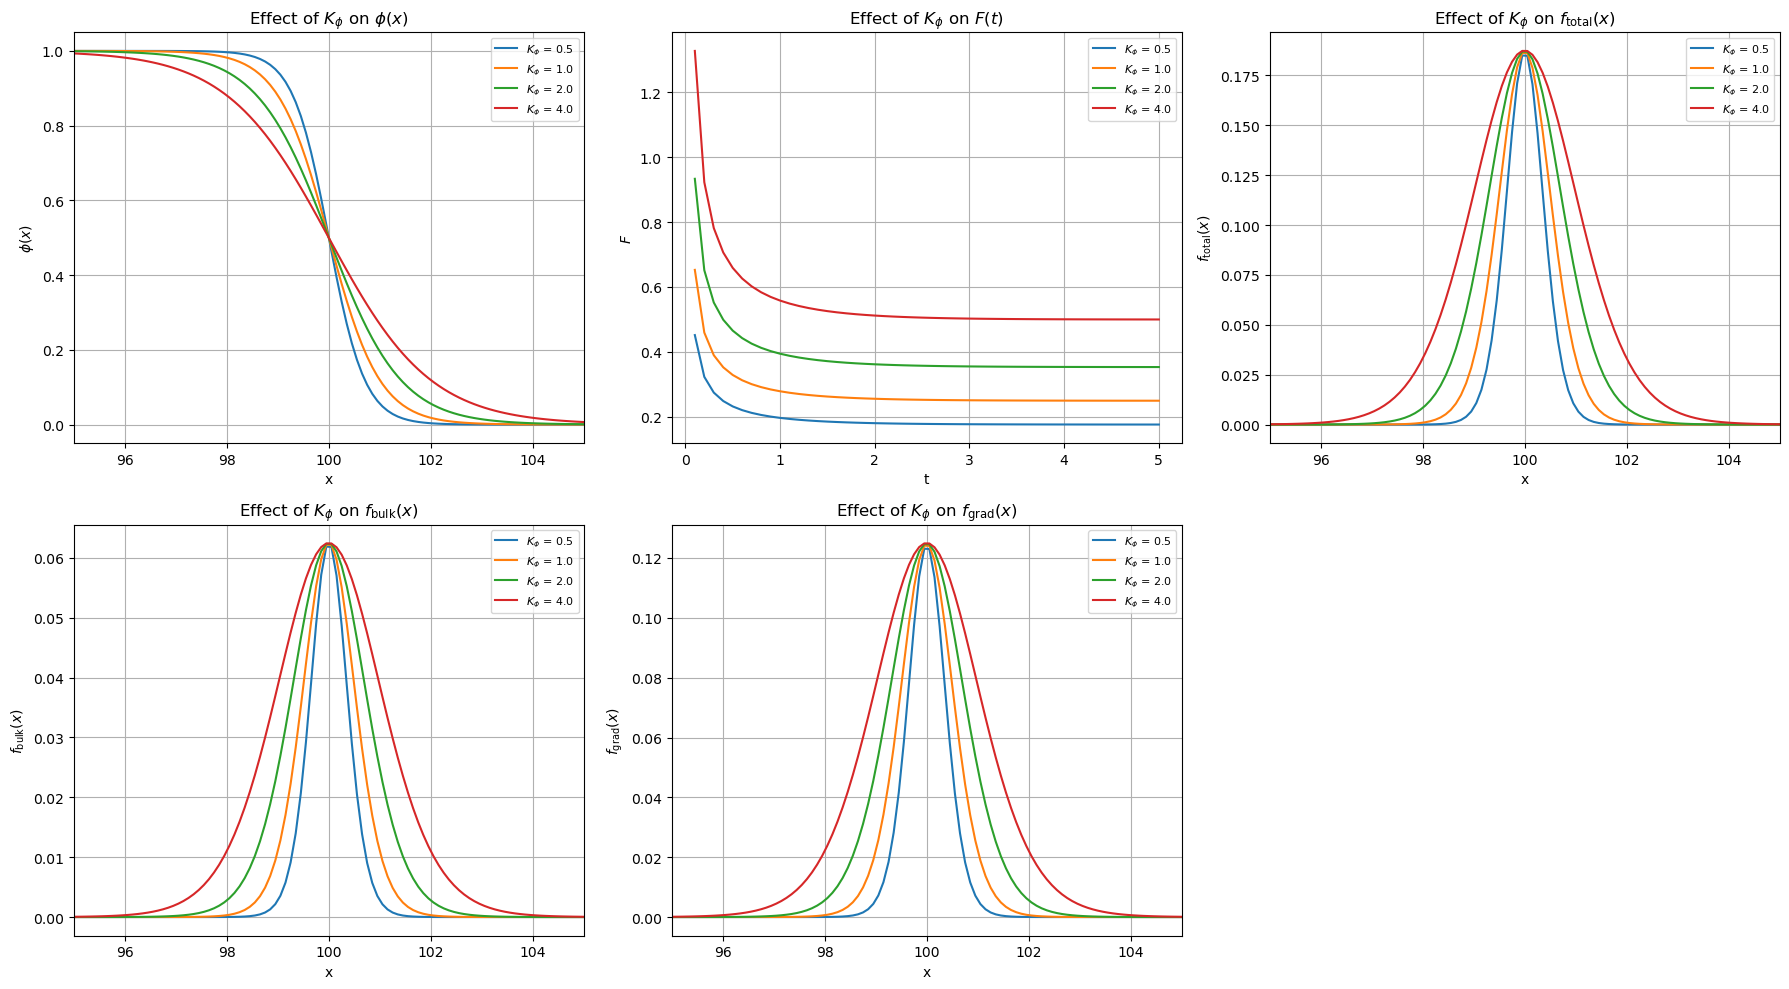

In [3]:
'''Influence of K_phi on the phase-field evolution and energy landscape'''

K_phi_values = [0.5, 1.0, 2.0, 4.0]
f_0_fixed = 1.0
L_fixed   = 1.0

# Collect simulation results
results = []
for K_phi in K_phi_values:
    x, phi, f_bulk, f_grad, f_total, t, F = run_simulation(f_0=f_0_fixed, L=L_fixed, K_phi=K_phi)
    results.append((K_phi, x, phi, f_bulk, f_grad, f_total, t, F))  # (K_phi, ...)

# Create subplot layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define what to plot
plot_configs = [
    {"ylabel": r"$\phi(x)$",        "xlabel": "x", "title": r"Effect of $K_\phi$ on $\phi(x)$"}, # phi
    {"ylabel": r"$F$",              "xlabel": "t", "title": r"Effect of $K_\phi$ on $F(t)$"}, # F
    {"ylabel": r"$f_{\rm total}(x)$","xlabel": "x", "title": r"Effect of $K_\phi$ on $f_{\rm total}(x)$"}, # f_total
    {"ylabel": r"$f_{\rm bulk}(x)$", "xlabel": "x", "title": r"Effect of $K_\phi$ on $f_{\rm bulk}(x)$"}, # f_bulk
    {"ylabel": r"$f_{\rm grad}(x)$", "xlabel": "x", "title": r"Effect of $K_\phi$ on $f_{\rm grad}(x)$"}, # f_grad
]

# Plotting everything
XMIN, XMAX = 95, 105

for i, cfg in enumerate(plot_configs):
    ax = axes[i]
    for K_phi, x, phi, f_bulk, f_grad, f_total, t, F in results:
        y = [phi, F, f_total, f_bulk, f_grad][i]
        ax.plot(t if i==1 else x, y, label=rf"$K_\phi$ = {K_phi}")
    ax.set_title(cfg["title"], fontsize=12)
    ax.set_xlabel(cfg["xlabel"]); ax.set_ylabel(cfg["ylabel"])
    ax.legend(fontsize=8); ax.grid(True)
    # Apply zoom to x–dependent plots
    if i != 1:
        ax.set_xlim(XMIN, XMAX)

# Remove last empty subplot
if len(plot_configs) < len(axes):
    fig.delaxes(axes[-1])
plt.tight_layout(); plt.show()


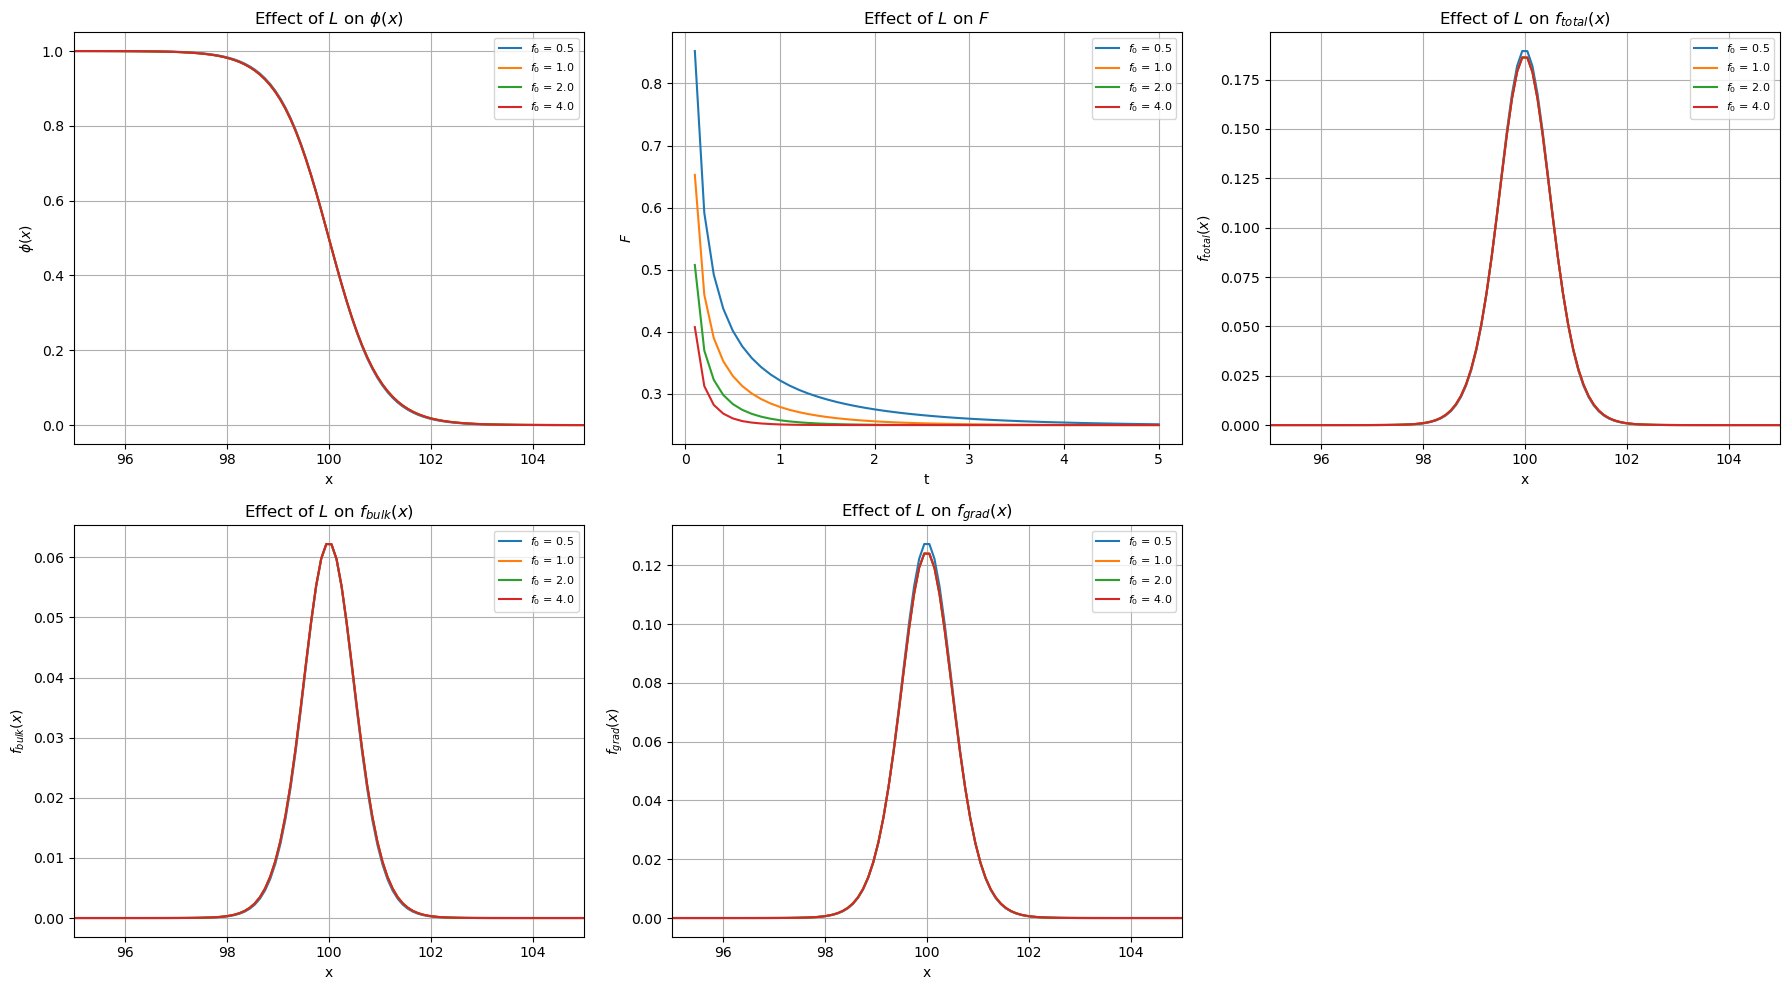

In [4]:
'''Influence of L on the phase-field evolution and energy landscape'''

L_values = [0.5, 1.0, 2.0, 4.0]
K_phi_fixed = 1.0
f_0_fixed = 1.0

# Collect simulation results for varying L
results = []
for L in L_values:
    result = run_simulation(f_0=f_0_fixed, L=L, K_phi=K_phi_fixed)
    results.append((L, *result))  # (L, x, phi, f_bulk, f_grad, f_total, t, F)

# Create subplot layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define what to plot
plot_configs = [
    {"ylabel": r"$\phi(x)$", "xlabel": "x", "title": r"Effect of $L$ on $\phi(x)$"},
    {"ylabel": r"$F$", "xlabel": "t", "title": r"Effect of $L$ on $F$"},
    {"ylabel": r"$f_{total}(x)$", "xlabel": "x", "title": r"Effect of $L$ on $f_{total}(x)$"},
    {"ylabel": r"$f_{bulk}(x)$", "xlabel": "x", "title": r"Effect of $L$ on $f_{bulk}(x)$"},
    {"ylabel": r"$f_{grad}(x)$", "xlabel": "x", "title": r"Effect of $L$ on $f_{grad}(x)$"},
]

# Plotting everything
XMIN, XMAX = 95, 105   # fixed zoom region around the interface

for i, cfg in enumerate(plot_configs):
    ax = axes[i]
    for f_0, x, phi, f_bulk, f_grad, f_total, t, F in results:
        y = [phi, F, f_total, f_bulk, f_grad][i]
        x_plot = t if i == 1 else x
        ax.plot(x_plot, y, label=rf"$f_0$ = {f_0}")

    ax.set_title(cfg["title"], fontsize=12)
    ax.set_xlabel(cfg["xlabel"])
    ax.set_ylabel(cfg["ylabel"])
    ax.legend(fontsize=8)
    ax.grid(True)

    # Apply zoom to x–dependent plots
    if i != 1:  
        ax.set_xlim(XMIN, XMAX)

# Remove last empty subplot
if len(plot_configs) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

F_bulk = 0.236697 J/m²
F_grad = 0.236826 J/m²
F_inte = 0.473523 J/m²


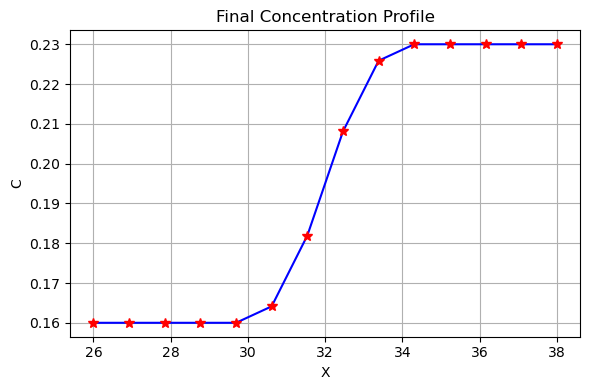

In [5]:
import numpy as np

# Mesh and Variables
dx = 1e-8
L  = 14e-8
nx = int(L/dx)
mesh = Grid1D(dx=dx, nx=nx)
x = mesh.cellCenters[0]

c = CellVariable(mesh=mesh, hasOld=True, name="c")
mu = CellVariable(mesh=mesh, name="μ")


c_gamma_eq       = 0.16
c_gamma_prime_eq = 0.23

# Initial condition (noise around 0.195)
c.setValue(c_gamma_eq)
c.setValue(c_gamma_prime_eq, where=x > L/2)


# Boundary conditions (Dirichlet on the left for c, Neumann on the right)
c.constrain(c_gamma_eq,    where=mesh.facesLeft)
c.faceGrad.constrain(0.,   where=mesh.facesRight)

# No‐flux for μ on both ends

# Parameters
K_c = 3.9e-6 # J/m
V_m = 1e-5 # m^3/mol
M = 1e-17 * ( V_m ) ** 2  # m^5/(J*s)
f_0 = 9.989e7 # J/m^3

# Polynomial coefficients for d²f_bulk/dc² expansion
a = 2
b = -3*(c_gamma_prime_eq + c_gamma_eq)
d = c_gamma_prime_eq**2 + 4*c_gamma_prime_eq*c_gamma_eq + c_gamma_eq**2
e = -c_gamma_prime_eq**2 * c_gamma_eq - c_gamma_prime_eq * c_gamma_eq**2

# Helper to recompute μ = δF/δc
def update_mu():
    dfdc = 2*f_0*(a*c**3 + b*c**2 + d*c + e)
    lap = c.faceGrad.divergence
    mu.setValue(dfdc - K_c*lap)

# Build the CH‐style equation manually
eq = TransientTerm(var=c) == DiffusionTerm(coeff=M, var=mu)

# Initialize μ at t=0

# Time stepping
dt    = 1e-2   # given
steps = 100

times, inte_energies, bulk_energies, grad_energies = [], [], [], []

for step in range(steps):
    c.updateOld()

    # Implicit solve for c (semi‐implicit in μ)
    update_mu()
    eq.solve(var=c, dt=dt)

    # Clamp into [c_gamma_eq, c_gamma_prime_eq] to prevent overshoot
    c.setValue(np.clip(c.value, c_gamma_eq, c_gamma_prime_eq))

    # Recompute μ for energy calc
    update_mu()

    # Compute total free energy F = ∫[f_bulk + ½ K |∇c|²] dV
    f_bulk = (f_0*(c_gamma_prime_eq - c)**2 * (c - c_gamma_eq)**2).value / V_m
    f_grad = (0.5*K_c * c.grad.mag**2).value

    F_inte = float((f_bulk + f_grad) @ mesh.cellVolumes)
    F_bulk = float( f_bulk @ mesh.cellVolumes)
    F_grad = float( f_grad @ mesh.cellVolumes)
    
    times.append((step+1)*dt)
    bulk_energies.append(F_bulk)
    grad_energies.append(F_grad)
    inte_energies.append(F_inte)


print(f"F_bulk = {bulk_energies[-1]:.6f} J/m²")
print(f"F_grad = {grad_energies[-1]:.6f} J/m²")
print(f"F_inte = {inte_energies[-1]:.6f} J/m²")


# Final c(x)
# Map physical coordinates to x = 26 to 38
x_plot = np.linspace(26, 38, len(x.value))

plt.figure(figsize=(6, 4))
plt.plot(x_plot, c.value, 'b-', marker='*', markersize=7, markerfacecolor='red', markeredgecolor='red')
plt.xlabel("X")
plt.ylabel("C")
plt.title("Final Concentration Profile")
plt.grid(True)
plt.tight_layout()
plt.show()

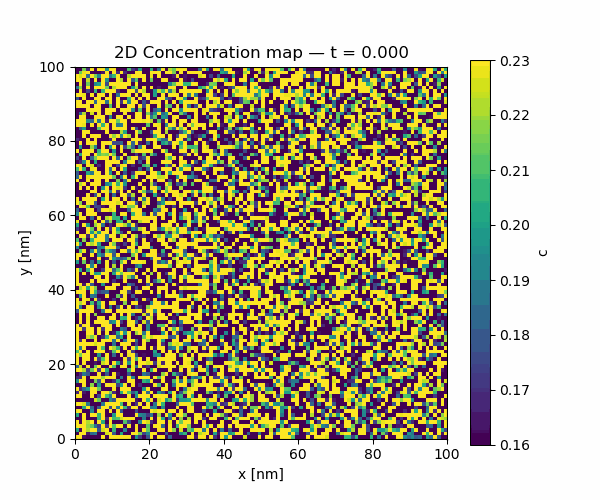

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

# Mesh and Variables
dx = 1e-8
Lx  = 100e-8
nx = int(Lx/dx)

dy = 1e-8
Ly  = 100e-8
ny = int(Ly/dy)

mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)
x = mesh.cellCenters[0]

c = CellVariable(mesh=mesh, hasOld=True, name="c")
mu = CellVariable(mesh=mesh, name="μ")
mu.faceGrad.constrain(0., where=mesh.exteriorFaces)  # ∂μ/∂n = 0 → no mass flux

c_gamma_eq       = 0.16
c_gamma_prime_eq = 0.23

# Initial condition (noise around 0.195)
c0 = GaussianNoiseVariable(mesh=mesh, mean=(c_gamma_eq + c_gamma_prime_eq)/2, variance=0.01, hasOld=0)
c.setValue(value=c0.value)

# Parameters
K_c = 2.45e-7 # J/m
V_m = 1e-5    # m^3/mol
M = 1e-17 * (V_m)**2  # m^5/(J*s)
f_0 = 9.989e7 # J/m^3

# Polynomial coefficients for d²f_bulk/dc² expansion
a = 2
b = -3*(c_gamma_prime_eq + c_gamma_eq)
d = c_gamma_prime_eq**2 + 4*c_gamma_prime_eq*c_gamma_eq + c_gamma_eq**2
e = -c_gamma_prime_eq**2 * c_gamma_eq - c_gamma_prime_eq * c_gamma_eq**2

# Helper to recompute μ = δF/δc
def update_mu():
    dfdc = 2*f_0*(a*c**3 + b*c**2 + d*c + e)
    lap = c.faceGrad.divergence
    mu.setValue(dfdc - K_c*lap)

# Build the CH‐style equation manually
eq = TransientTerm(var=c) == DiffusionTerm(coeff=M, var=mu)

# Time stepping
dt    = 0.01
steps = 1000

# Normalized times displayed as frames
frame_times = np.linspace(0.0, 1.0, 21)                 # [0.0, 0.1, ..., 1.0]
frame_steps = np.rint(frame_times * steps).astype(int)
frame_steps = np.clip(frame_steps, 0, steps)            # safety

# Ensure μ is consistent with the initial c before stepping
update_mu()

# Initial image
fig, ax = plt.subplots(figsize=(6, 5))
img = ax.imshow(
    np.flipud(np.reshape(c.value, (ny, nx))),
    extent=(0, Lx * 1e8, 0, Ly * 1e8),
    cmap='viridis',
    aspect='equal',
    vmin=c_gamma_eq,
    vmax=c_gamma_prime_eq,
    animated=True,
)
fig.colorbar(img, ax=ax, label="c")
ax.set_xlabel("x [nm]")
ax.set_ylabel("y [nm]")
title = ax.set_title("2D Concentration map — t = 0.000")

# Advance from previous frame's step -> target step
prev_step = {'i': 0}

def single_step():
    c.updateOld()
    update_mu()
    eq.solve(var=c, dt=dt)
    update_mu()

def update(frame_idx):
    target_step = frame_steps[frame_idx]
    for _ in range(prev_step['i'], target_step):
        single_step()
    prev_step['i'] = target_step

    img.set_data(np.flipud(np.reshape(c.value, (ny, nx))))
    t_norm = target_step / steps
    title.set_text(f"2D Concentration map — t = {t_norm:0.3f}")
    return (img, title)

anim = FuncAnimation(
    fig, update, frames=len(frame_steps),
    interval=400, blit=False, repeat=False
)


# Display the GIF inline
gif_path = "ch_2d.gif"
anim.save(gif_path, writer=PillowWriter(fps=12))

plt.close(fig)

display(Image(filename=gif_path))